In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import cmocean
import math
#for removing warnings
import warnings

In [14]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://velocity-u.zarr'
data_path2 = 's3://velocity-v.zarr'
data_path3 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path4 = 's3://data/modmoor_varianceII.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)
remote_files4 = fsg.glob(data_path4)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)
store4 = s3fs.S3Map(root=data_path4, s3=fsg, check=False)

du = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dzz = xr.open_zarr(store=store3, consolidated=True)
dvv = xr.open_zarr(store=store4, consolidated=True)

In [7]:
p_list = [[912,  10],
         [900, 233],
         [758,110],
         [870, 600],
         [820, 200],
         [475, 525],
         #[197, 900],#
         [530, 625],
         [530, 985]] #
vec_l = [np.array([[-0.22053145, -0.97537986],
       [-0.97537986,  0.22053145]]), 
        np.array([[ 0.48647393, -0.87369509],
       [-0.87369509, -0.48647393]]), 
        np.array([[ 7.83498519e-05, -5.45221032e-05],
     [-5.45221032e-05,  6.06174301e-05]]), 
        np.array([[-0.35547167, -0.93468706],
       [-0.93468706,  0.35547167]]), 
        np.array([[ 0.74498577, -0.66708036],
       [ 0.66708036,  0.74498577]]), 
        np.array([[ 0.84606207,  0.53308439],
       [-0.53308439,  0.84606207]]), 
       # np.array([[0., 1.],
       #[1., 0.]]),
        np.array([[-0.55922323, -0.82901712],
       [-0.82901712,  0.55922323]]), 
        np.array([[0., 1.],
       [1., 0.]])]
theta_l = [-102.74024975915854, 
           -60.89091453193666, 
           -108.54874729301497, 
           -110.82235477282119, 
           41.842123241213486, 
           -32.21409257613994, 
           90.0, 
           -124.00209580860839, 
           90.0]
c_list = ['c', 'orangered', 'g',
          'r', 'm', 'y','tab:orange',
          'tab:pink', 'limegreen', 'maroon', 
          'dodgerblue', 'gold', 'peru','deeppink',
          'gold','peru','dodgerblue','c','m']

In [15]:
var_ = dvv.var_
var_

<xarray.DataArray 'var_' (depth: 75, variance: 17)>
dask.array<xarray-var_, shape=(75, 17), dtype=float64, chunksize=(75, 17), chunktype=numpy.ndarray>
Dimensions without coordinates: depth, variance

In [8]:
u = du.vozocrtx.isel(x=slice(200,1400),y=slice(650,1800))
u = u.rename({'depthu' : 'depth'})
v = dv.vomecrty.isel(x=slice(200,1400),y=slice(650,1800))
v = v.rename({'depthv' : 'depth'})

bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800)).squeeze(axis=0)

In [9]:
not_ice = [(912,10),(900,233),(758,110)]
ice_slope = [(870,600),(820,200),(475,525),(197,900)]
ice_not_slope = [(530,625),(530,985)]

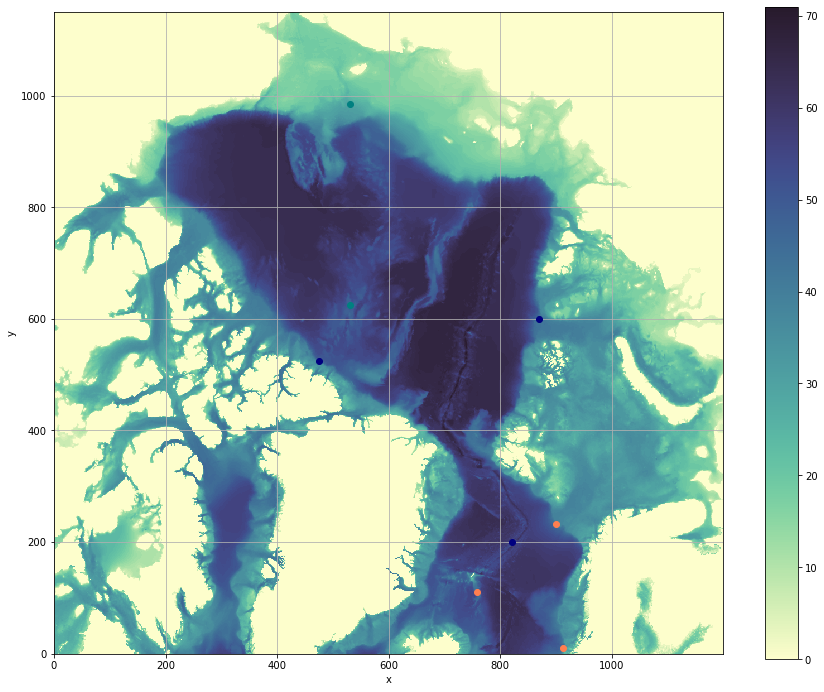

In [10]:
c_l = ['coral','coral','coral','navy','navy','navy','teal','teal']
fig, ax = plt.subplots(figsize=(15,15))
cmap = plt.get_cmap(cmocean.cm.deep)
c = bathym.plot(cmap=cmap, add_colorbar=False)
for i,p in enumerate(p_list):
    x = p[0]
    y = p[1]
    ax.plot(x, y, marker='o', color=c_l[i])
fig.colorbar(c,
             shrink=0.8,
             #label=r"Depth [m]"
            )
ax.grid('on')
#ax.plot(758,110,marker='o', color='r')
#ax.set_xlim(500,700)
#ax.set_ylim(900,1000)
ax.set_aspect('equal')

In [11]:
def PC(data):
    cov = np.cov(data.T, bias=True) # uten .T ble den en 73x73 matrise     
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]

    return  values, vectors

In [17]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = bathym.isel(x=x, y=y).values

    u_ = u.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    v_ = v.isel(x=x, y=y, depth = slice(0,d-1))
    
    valu, vecu = PC(u_)
    valv, vecv = PC(v_)
    
    PC1u = (np.sqrt(valu[0])*vecu[:,0])
    PC1v = (np.sqrt(valv[0])*vecv[:,0])
    
    PVE1u = int(round(valu[0]/np.sum(valu)*100,0))
    PVE1v = int(round(valv[0]/np.sum(valv)*100,0))
    
    return PC1u, PC1v, dypu, dypv, PVE1u, PVE1v

'Making a function for the vertical PC'
def PCz_op(x,y,vec):
    
    d = bathym.isel(y=y, x=x).values
    up = u.isel(y=y, x=x, depth=slice(0,d-1))
    vp = v.isel(y=y, x=x, depth=slice(0,d-1))
    print(vec[0],vec[1])
    print(up.shape)
    
    vel_p = (up*vec[0] + vp*vec[1])/(np.sqrt(vec[0]**2 + vec[1]**2))
    vel_o = (-up*vec[1] + vp*vec[0])/(np.sqrt(vec[0]**2 + vec[1]**2))
    
    valp, vecp = PC(vel_p)
    valo, veco = PC(vel_o)
    
    PC1p = (np.sqrt(valp[0])*vecp[:,0])
    PC1o = (np.sqrt(valo[0])*veco[:,0])
    
    PVE1p = int(round(valp[0]/np.sum(valp)*100,0))
    PVE1o = int(round(valo[0]/np.sum(valo)*100,0))
    
    return PC1p, PC1o, up, vp, PVE1p, PVE1o

def ellipse(x,y,d):
    
    #d = bathym.isel(y=y, x=x).values
    covm = np.cov(np.vstack([u.isel(x=x, y=y, depth=d).values,v.isel(x=x, y=y, depth=d).values]))
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    
    # ellipser :
    major = np.sqrt(values[0])
    minor = np.sqrt(np.abs(values[1]))
    
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = vectors[:,0][0], vectors[:,0][1]
    #theta = np.arctan(vy/vx)#*(180/math.pi)
    theta = np.arctan2(vy, vx)*(180/math.pi)
    
    return major, minor, theta, vectors

def tot_var(x,y):
    d = bathym.isel(y=y, x=x).values
    up = u.isel(y=y, x=x, depth=slice(0,d-1))
    vp = v.isel(y=y, x=x, depth=slice(0,d-1))
    for i in range(len(up.depth)):
        var[i] = np.sqrt(np.var(up.isel(depth=i).values) + np.var(vp.isel(depth=i).values))
    return var

## Finding vector

In [74]:
for p in not_ice: 
    x=p[0]
    y=p[1]
    print(bathym.isel(x=x,y=y).values)
for p in ice_slope: 
    x=p[0]
    y=p[1]
    print(bathym.isel(x=x,y=y).values)
for p in ice_not_slope: 
    x=p[0]
    y=p[1]
    print(bathym.isel(x=x,y=y).values)

46
44
31
43
57
42
21
48
30


In [85]:
p_list = []
p_list = np.concatenate((not_ice,ice_slope,ice_not_slope))
p_list

array([[912,  10],
       [900, 233],
       [707, 234],
       [870, 600],
       [820, 200],
       [475, 525],
       [197, 900],
       [530, 625],
       [530, 985]])

In [33]:
print(bathym.isel(x=758,y=110).values)

49


In [35]:
#d_ = [30,30,20,30,35,30,25,10,30,20] 
maj_l = []
min_l = []
theta_l = []
vec_l = []

for i, m in enumerate([(758,110)]):
    print(i)
    x = m[0]
    y = m[1]
    d = 35
    covm = np.cov(np.vstack([u.isel(x=x, y=y, depth=d).values,v.isel(x=x, y=y, depth=d).values]))
    print(covm)
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    #theta_l.append(theta_)
    vec_l.append(vectors)  

0
[[ 7.83498519e-05 -5.45221032e-05]
 [-5.45221032e-05  6.06174301e-05]]


In [103]:
print(vec_l)
print('--------')
print(maj_l)
print('--------')
print(min_l)
print('--------')
print(theta_l)

[array([[0., 1.],
       [1., 0.]])]
--------
[0.0]
--------
[0.0]
--------
[90.0]


## Ice free

-0.22053145 -0.97537986
(73, 45)
model days done


NameError: name 'var' is not defined

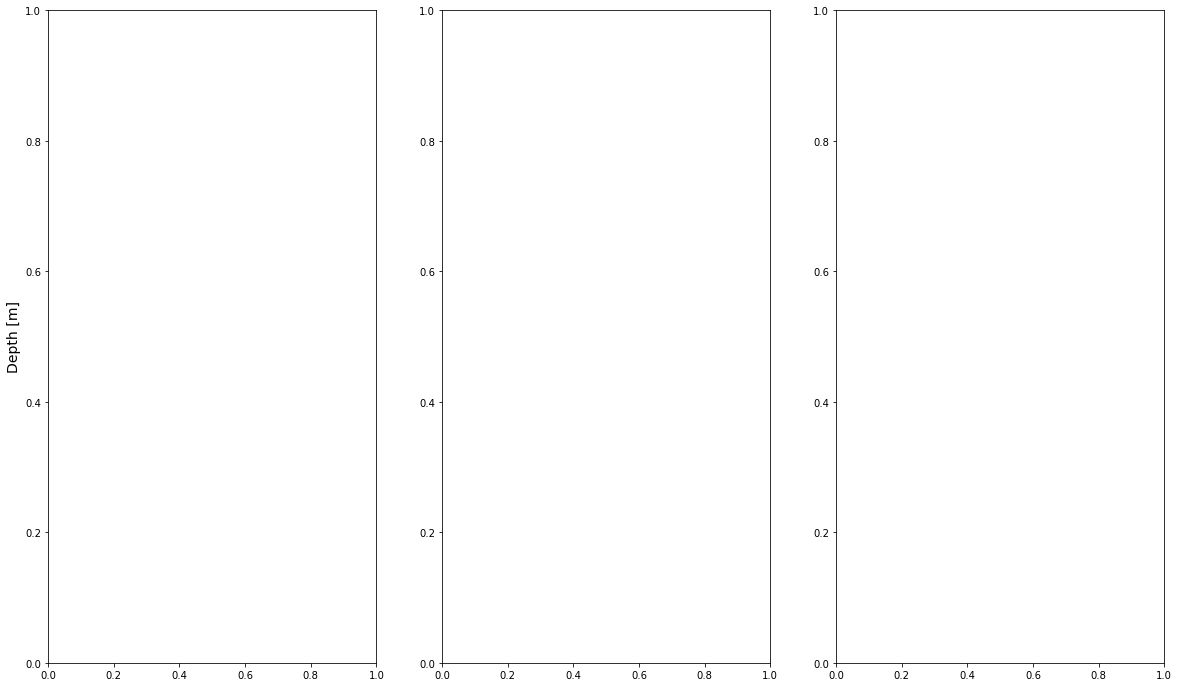

In [18]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,12))
#plt.suptitle('EOF1 & EOF1-rotated from model data, ice free regions', 
#             horizontalalignment='center',
#            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [0,1,2]):
    x = p_list[i][0]
    y = p_list[i][1]
    vec = vec_l[i][:,0]  
    PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
    
    print('model days done')
    # tot. varians model
    var_mo = tot_var(x,y)
    
    axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='darkred')
    axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='coral')    
    axs.plot(PC1u,dypu.depth, 'darkred', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'coral', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(var_mo,dypu, linestyle='-.', label= f'$\sigma^2$ model', color='r')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="lower left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFs_icefree_mod.pdf', dpi = 300)

## ice and sloe

In [ ]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (22,12))
#plt.suptitle('EOF1 & EOF1-rotated from model data, ice rgions on the slope', 
#             horizontalalignment='center',
#            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [3,4,5]):
    x = p_list[i][0]
    y = p_list[i][1]
    vec = vec_l[i][:,0]  
    PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
    print('model days done')
    # tot. varians model
    var_mo = tot_var(x,y)
    
    axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='b')
    axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='steelblue')    
    axs.plot(PC1u,dypu.depth, 'b', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'steelblue', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(var_mo,dypu, linestyle='-.', label= f'$\sigma^2$ model', color='deepbluesky')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="lower left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFs_iceslope_mod.pdf', dpi = 300)

## ice and flat bottom

-0.55922323 -0.82901712
(73, 47)
0.0 1.0
(73, 29)


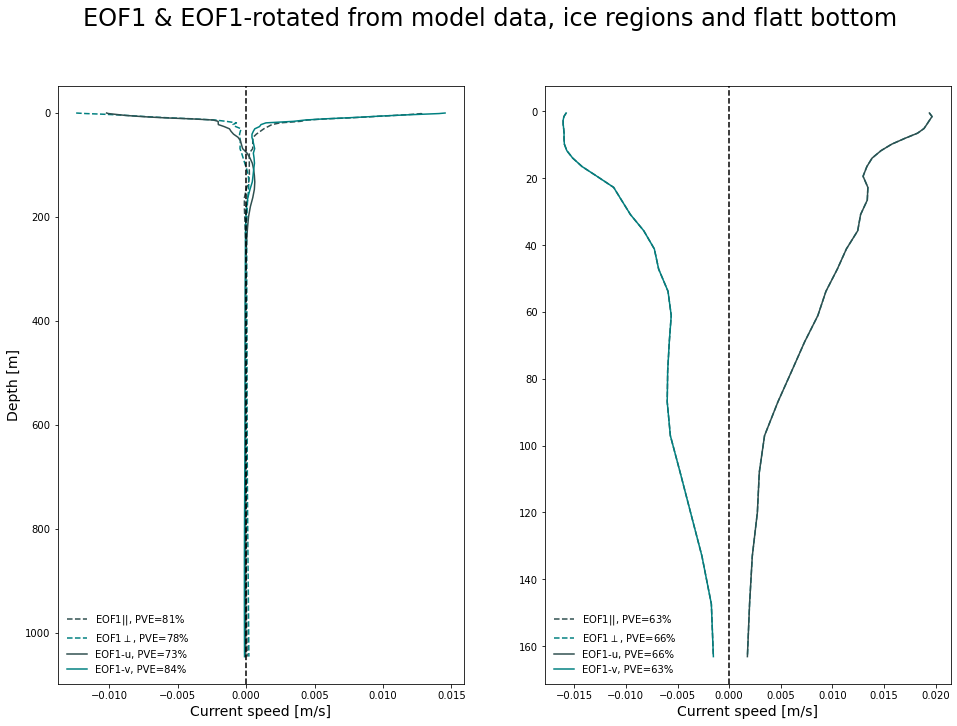

In [123]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,2,figsize = (16,11))
plt.suptitle('EOF1 & EOF1-rotated from model data, ice regions and flatt bottom', 
             horizontalalignment='center',
            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)

for axs, i in zip(axes.flat, [6,7]):
    x = p_list[i][0]
    y = p_list[i][1]
    vec = vec_l[i][:,0]  
    PC1p, PC1o, dypu, dypv, PVE1p, PVE1o = PCz_op(x,y,vec)
    PC1u, PC1v, dypu, dypv, PVE1u, PVE1v = PCz(x,y)
    
    
    axs.plot(PC1p,dypu.depth, linestyle='--', label= f'EOF1$||$, PVE={PVE1p}%', color='deepskyblue')
    axs.plot(PC1o,dypv.depth, linestyle='--', label= f'EOF1$\perp$, PVE={PVE1o}%', color='teal')    
    axs.plot(PC1u,dypu.depth, 'deepskyblue', label = f'EOF1-u, PVE={PVE1u}%')
    axs.plot(PC1v,dypv.depth, 'teal', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(var_mo,dypu, linestyle='-.', label= f'$\sigma^2$ model', color='k')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="lower left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    
plt.savefig('EOFs_iceflatt_mod.pdf', dpi = 300)